# 🌳🌳🌳 Решающие деревья, случайный лес

✅ Реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. 
- При решении задачи регрессии используйте дисперсию подвыборки
- При решении задачи классификации используйте критерий Джини

Функцию`find_best_split` протестируйте на датасете `Boston` из `sklearn`

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. 

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
boston = pd.read_csv("boston_house_prices.csv")
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
X = boston.drop("MEDV", axis = 1)
y = boston["MEDV"]

In [8]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [9]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis/variances: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best/variance_best: оптимальное значение критерия Джини/дисперсии (число)
    """
    if feature_type == 'real':
        # отсортируем значения признака и целевую переменную
        sorted_indices = np.argsort(feature_vector)
        sorted_features = feature_vector[sorted_indices]
        sorted_targets = target_vector[sorted_indices]

        # найдем все пороги как среднее двух соседних значений признака
        thresholds = (sorted_features[1:] + sorted_features[:-1]) / 2
        best_criteria = float('inf')
        best_threshold = thresholds[0]

        if task == 'classification':
            # массив для значений критерия Джини
            ginis = []

            for threshold in thresholds:
                left_indices = sorted_features <= threshold
                right_indices = sorted_features > threshold

                # Проверяем, что подвыборки не пустые
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                # подсчет количества объектов каждого класса
                left_counts = Counter(sorted_targets[left_indices])
                right_counts = Counter(sorted_targets[right_indices])

                # рассчитаем доли классов
                left_size = np.sum(left_indices)
                right_size = np.sum(right_indices)

                # рассчитаем критерий Джини
                left_gini = 1.0 - sum((count / left_size) ** 2 for count in left_counts.values())
                right_gini = 1.0 - sum((count / right_size) ** 2 for count in right_counts.values())

                gini = (left_size / len(target_vector)) * left_gini + (right_size / len(target_vector)) * right_gini
                ginis.append(gini)

                # обновим значение критерия Джини и порог
                if gini < best_criteria:
                    best_criteria = gini
                    best_threshold = threshold

            return thresholds, ginis, best_threshold, best_criteria

        elif task == 'regression':
            # массив для значений дисперсий
            variances = []

            for threshold in thresholds:
                left_indices = sorted_features <= threshold
                right_indices = sorted_features > threshold

                # Проверяем, что подвыборки не пустые
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                left_variance = np.var(sorted_targets[left_indices])
                right_variance = np.var(sorted_targets[right_indices])

                # найдем размеры подвыборок
                left_size = np.sum(left_indices)
                right_size = np.sum(right_indices)

                # Рассчитываем взвешенную дисперсию для текущего порога
                variance = (left_size / len(target_vector)) * left_variance + (right_size / len(target_vector)) * right_variance
                variances.append(variance)

                # обновим значение дисперсии и порог
                if variance < best_criteria:
                    best_criteria = variance
                    best_threshold = threshold

            return thresholds, variances, best_threshold, best_criteria

    # для категориальных признаков почти то же самое
    elif feature_type == 'categorical':
        unique_values = np.unique(feature_vector)
        best_criteria = float('inf')
        best_threshold = unique_values[0]

        if task == 'classification':
            ginis = []

            for value in unique_values:
                left_indices = feature_vector == value
                right_indices = feature_vector != value

                # Проверяем, что подвыборки не пустые
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                left_counts = Counter(target_vector[left_indices])
                right_counts = Counter(target_vector[right_indices])

                left_size = np.sum(left_indices)
                right_size = np.sum(right_indices)

                left_gini = 1.0 - sum((count / left_size) ** 2 for count in left_counts.values())
                right_gini = 1.0 - sum((count / right_size) ** 2 for count in right_counts.values())

                gini = (left_size / len(target_vector)) * left_gini + (right_size / len(target_vector)) * right_gini
                ginis.append(gini)

                if gini < best_criteria:
                    best_criteria = gini
                    best_threshold = value
            return unique_values, ginis, best_threshold, best_criteria

        elif task == 'regression':
            variances = []

            for value in unique_values:
                left_indices = feature_vector == value
                right_indices = feature_vector != value

                # Проверяем, что подвыборки не пустые
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                left_variance = np.var(target_vector[left_indices])
                right_variance = np.var(target_vector[right_indices])

                left_size = np.sum(left_indices)
                right_size = np.sum(right_indices)

                variance = (left_size / len(target_vector)) * left_variance + (right_size / len(target_vector)) * right_variance
                variances.append(variance)

                if variance < best_criteria:
                    best_criteria = variance
                    best_threshold = value
            return unique_values, variances, best_threshold, best_criteria
            


In [10]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

**Посмотрим на самый оптимальный порог**

In [11]:
print(f'Best threshold: {threshold_best}')
print(f'Best variance: {variance_best}')

Best threshold: 6.68632
Best variance: 68.08324641384722


**Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.**

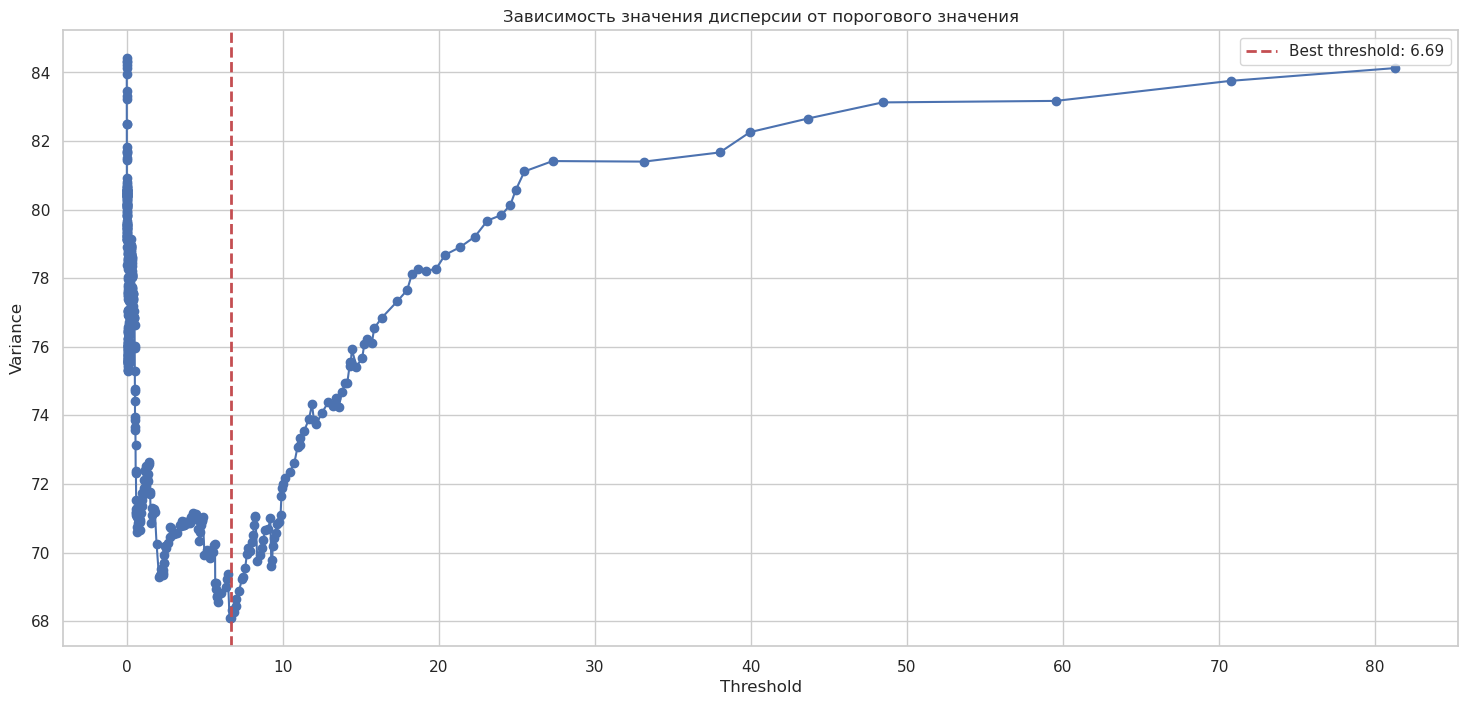

In [28]:
# Построим график зависимости дисперсии от порога
plt.figure(figsize=(18, 8))
plt.plot(thresholds, variances, marker='o')
plt.axvline(threshold_best, color='r', linestyle='--', linewidth = 2, label=f'Best threshold: {threshold_best:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Variance')
plt.title('Зависимость значения дисперсии от порогового значения')
plt.legend()
plt.grid(True)
plt.show()
